# Could Model Wind Turbine Load Predictor

In this notebook it is possible to train, test and see the predicted results of a pretrained Wind Load Prediction model.

To do this you have to update the Inputs cell below with the correct information. 
Next you have to click Run All and the model will be trained and tested on the given Dataset. The data concists of 10 minute long simulations. The prediction vs true value graphs that are plotted below each contain 1/3 of the simulation so the differences (or similarities) between the predictions and true values are better visible.
In the cell below "Train the Model" the hyperparameters of the model are defined and can be adjusted.

## Modules


In [1]:
#Import 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
from sklearn.model_selection import train_test_split
from scipy import interpolate

!pip install rainflow
import rainflow

from tqdm import tqdm
import matplotlib.pyplot as plt
from collections.abc import Iterable
from datetime import date
import os
import random
import math

print("Loading modules completed.")

Loading modules completed.


In [2]:
#Set device and output (the x or y moment)
load_x_or_y = 'y' 

# Define the directories containing the two linked file sets
input_data = '/kaggle/input/could-dataset2/dataset2/Inputs'
output_data = '/kaggle/input/could-dataset2/dataset2/Outputs'


## Dataloader

In [3]:
class WindTurbineDataset(Dataset):
    def __init__(self, input_files, target_files, scaling_factors, load_x_or_y, input_transform=None, target_transform=None):
        """
        Dataset class for Wind Turbine data with lazy loading.

        Parameters:
        -----------
        input_files: list of str, List of file paths for input data.
        target_files: list of str, List of file paths for target data.
        input_transform: callable, optional, A function or transformation to apply to the inputs.
        target_transform: callable, optional, A function or transformation to apply to the targets.
        """
        self.input_files = input_files
        self.target_files = target_files
        self.input_transform = input_transform
        self.target_transform = target_transform
        self.scaling_factors = scaling_factors
        self.load_x_or_y = load_x_or_y

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        # Load the input and target data for the given index
        angle_data = self._load_angles(self.target_files[idx])
        target_data = self._load_targets(self.target_files[idx])
        self.target_length = target_data.shape[0]
        Turbsim_data = self._load_inputs(self.input_files[idx])
        time_data = self._load_time(self.target_files[idx])
        
        # Apply global normalization
        Turbsim_data = self._normalize(Turbsim_data, self.scaling_factors["Turbsim_min"], self.scaling_factors["Turbsim_max"], to_range=(0, 1))
        angle_data = self._normalize(angle_data, self.scaling_factors["angle_min"], self.scaling_factors["angle_max"], to_range=(0, 1))

        return Turbsim_data, angle_data, target_data, time_data


    def _load_inputs(self, file_path):
        # Input data from shape (3, 1200, 41, 33) to (15000, 41, 33) to match the output lenght
        data = np.load(file_path)  
        target_length = self.target_length 
        current_length = data.shape[0]
    
        # Interpolation to the target length (15000 steps)
        time_steps_input = np.arange(current_length)  # 
        time_steps_target = np.linspace(0, current_length - 1, target_length)  
        interpolation_function = interpolate.interp1d(time_steps_input, data, kind='linear', axis=0)
        inputs_stretched = interpolation_function(time_steps_target)  # Result will have shape [15000, 41, 33]
        
        return torch.tensor(inputs_stretched).float()  
        

    def _load_targets(self, file_path):
        data = np.load(file_path)  
        if load_x_or_y == 'x' or load_x_or_y == 'X':
            data = data[:, 1]          # Keep only the RootMxb1 column
        elif load_x_or_y == 'y' or load_x_or_y == 'Y':
            data = data[:, 2]          # Keep only the RootMyb1 column
        return torch.tensor(data)
    
    def _load_angles(self, file_path):
        data = np.load(file_path)  
        data = data[:, 3]          # Keep only the Angles column
        return torch.tensor(data)  

    def _load_time(self, file_path):
        data = np.load(file_path)  
        data = data[:, 0]          # Keep only the Time column
        return torch.tensor(data)  

    @staticmethod
    def _normalize(data, min_val, max_val, to_range=(0, 1)):
        range_min, range_max = to_range
        normalized = (data - min_val) / (max_val - min_val + 1e-8)
        return normalized * (range_max - range_min) + range_min

    def shapes(self):
        sample_Turbsim, sample_angle, sample_target, sample_time = self[0]
        return sample_Turbsim.shape, sample_angle.shape, sample_target.shape, sample_time.shape

#Function for re-scaling
def _denormalize(normalized_data, min_val, max_val, from_range=(-1, 1)):
    range_min, range_max = from_range
    original = (normalized_data - range_min) / (range_max - range_min + 1e-8)
    return original * (max_val - min_val) + min_val

print("Defining Dataloader completed.")

Defining Dataloader completed.


## Train and Evaluation Functions

In [4]:
def train_one_epoch(model: nn.Module, 
                    dataset: Dataset, 
                    criterion: nn.modules.loss, 
                    optimizer: optim, 
                    device: torch.device=torch.device('cpu')
                    ) -> float:
    """
    Trains the model for one epoch.

    Parameters:
    -----------
    model: torch.nn.Module, The model to train
    dataset: Dataset, The training dataset
    criterion: torch.nn.modules.loss, The loss function
    optimizer: torch.optim, The optimizer
    device: torch.device, The device to use for training

    Returns:
    --------
    epoch_loss: float, The loss for the epoch
    """
    model.train()
    epoch_loss = 0
    for Turbsim, angle, target, time in dataset:
        Turbsim, angle, target, time = Turbsim.to(device), angle.to(device), target.to(device), time.to(device)
        optimizer.zero_grad()
        output = model(Turbsim, angle)
        output = _denormalize(output, scaling_factors['target_min'], scaling_factors['target_max'], from_range=(-1, 1)) #Rescale predictions
        target = target.unsqueeze(-1)  # Add a dimension at the end to make the shape (batch_size, seq_len, 1)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if device != torch.device('cpu'):
            torch.cuda.empty_cache()
    return epoch_loss


def train(model: nn.Module, 
          dataloader: DataLoader, 
          criterion: nn.modules.loss, 
          optimizer: optim, 
          n_epochs: int,
          device: torch.device=torch.device('cpu'),
          early_stopping_value: int=-1,
          print_freq: int=10
          ) -> tuple[nn.Module, list, list]:
    
    """
    Parameters:
    -----------
    model: torch.nn.Module, The model to train
    dataloader: torch.utils.data.DataLoader, The dataloader containing the training and validation data
    criterion: torch.nn.modules.loss, The loss function
    optimizer: torch.optim, The optimizer
    n_epochs: int, The number of epochs to train for
    device: torch.device, The device to use for training
    early_stopping: int, Whether to use early stopping or not
        Default: -1 = No early stopping applied
        Other values: The number of epochs to wait to see an improvement in the loss
    print_freq: int,The frequency to print the loss
        Default: 10
    
    Returns:
    --------
    model: torch.nn.Module, The trained model
    train_loss_history: list, The history of training losses
    val_loss_history: list, The history of validation losses
    """
    model.to(device)
    model.train()

    best_loss = float('inf')
    train_loss_history: list = []
    val_loss_history: list = []
    del_loss_history: list = []
    print("Training started")

    #Train the model
    for epoch in range(n_epochs):

        #Train one epoch and save the loss
        train_epoch_loss = train_one_epoch(model, dataloader['train'], criterion, optimizer, device)
        train_loss_history.append(train_epoch_loss)

        # Evaluate the model on the validation set
        val_epoch_loss, del_loss = evaluate(model, dataloader['validation'], criterion, device)
        val_loss_history.append(val_epoch_loss)
        del_loss_history.append(del_loss)

        # Print the loss
        print(f'Epoch: {epoch+1}/{n_epochs} Training Loss = {train_epoch_loss:.3f}, Validation Loss = {val_epoch_loss:.3f}, DEL = {del_loss:.3f}')

        if val_epoch_loss < best_loss:
            best_loss = val_epoch_loss
            
    return model, train_loss_history, val_loss_history, del_loss_history


def evaluate(model: nn.Module, 
             dataset: Dataset, 
             criterion: nn.modules.loss, 
             device: torch.device=torch.device('cpu')
             ) -> float:
    """
    Evaluates the model.

    Parameters:
    -----------
    model: torch.nn.Module, The model to evaluate
    dataloader: torch.utils.data.DataLoader, The dataloader containing the evaluation data
    criterion: torch.nn.modules.loss, The loss function
    device: torch.device, The device to use for evaluation
    
    Returns:
    --------
    loss: float, The loss for the evaluation
    """
    model.eval()
    loss = 0
    del_errors = []
    with torch.no_grad():
        for Turbsim, angles, target, time in dataset:
            Turbsim, angles, target, time = Turbsim.to(device), angles.to(device), target.to(device), time.to(device)
            output = model(Turbsim, angles)
            output = _denormalize(output, scaling_factors['target_min'], scaling_factors['target_max'], from_range=(-1, 1)) # Rescale predictions
            target = target.unsqueeze(-1)  # Add a dimension at the end to make the shape (batch_size, seq_len, 1)
            loss += criterion(output, target).item()
            del_errors.extend(calculate_del_error(output, target, time, m=10))
    return loss, np.mean(del_errors)

def calculate_del_error(batch_output: torch.Tensor, batch_target: torch.Tensor, batch_time: torch.Tensor, m=10) -> float:
    """
    Calculates the damage equivalent load error.

    Parameters:
    -----------
    output: torch.Tensor
        The batch of outputs from the model
    target: torch.Tensor
        The batch of target data
    time: troch.Tensor
        The time data
    m: int
        The Wohler exponent
        defualt: 10
    
    Returns:
    --------
    del_error: list
        The damage equivalent load error in percentage
    """
    del_errors = []
    
    for item_target, item_output, item_time in zip(batch_target, batch_output, batch_time):
        target_del = calculate_del(item_target, item_time, m)
        output_del = calculate_del(item_output, item_time, m)
        del_error = np.abs(output_del - target_del)/target_del * 100
        del_errors.append(del_error)
        
    return del_errors


def calculate_del(data: torch.Tensor, time: torch.Tensor, m: int, Teq: int=1) -> float:
    """
    Calculates the damage equivalent load.

    Parameters:
    -----------
    data: torch.Tensor
        The data to calculate the DEL for
    time: torch.Tensor
        The time data
    m: int
        The Wohler exponent
    Teq: int
        The equivalent time
        default: 1
    
    Returns:
    --------
    DEL: float
        The damage equivalent load
    """
    data = data.to('cpu').numpy().flatten()
    time = time.to('cpu').numpy().flatten()
    cycles = rainflow.count_cycles(data, nbins=100)

    neq = time[-1]/Teq
    DELi = 0
    for rng, count in cycles:
        DELi += rng**m * count / neq
        
    return DELi**(1/m)

## Plotting Functions

In [5]:
def plot_losses(train_loss_history: Iterable, val_loss_history: Iterable, del_loss_history: Iterable) -> None:
    """
    Plots the training, validation losses and DEL difference over epochs.

    Parameters:
    -----------
    train_loss_history: Iterable, The history of training losses
    val_loss_history: Iterable, The history of validation losses
    """
    fig, ax = plt.subplots(1, 3, figsize=(12, 6))
    ax[0].plot(train_loss_history, label='Training Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Training Loss')
    ax[0].legend()

    ax[1].plot(val_loss_history, label='Validation Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_title('Validation Loss')
    ax[1].legend()

    ax[2].plot(del_loss_history, label='Validation Loss')
    ax[2].set_xlabel('Epoch')
    ax[2].set_ylabel('Loss')
    ax[2].set_title('Del Loss')
    ax[2].legend()

    fig.show()


def plot_predictions(model, dataloader, num_plots=1, num_parts=1, device='cuda' if torch.cuda.is_available() else 'cpu', only_plot_pred="no"):
    """
    Plots randomly selected predicted vs. true values for a given dataloader using a pretrained model.

    Args:
        model: Pretrained PyTorch model.
        dataloader: DataLoader containing the data to evaluate.
        num_plots (int): Number of plots to generate.
        device (str): Device to run the model on ('cuda' or 'cpu').
        only_plot_pred (str): If "yes", only plot the predictions.
    """
    model.to(device)
    model.eval()

    # Gather all data from the dataloader for random sampling
    all_predictions, all_true_values = [], []
    with torch.no_grad():
        for batch in dataloader:
            Turbsim, angles, true_outputs, optimizer = batch
            Turbsim = Turbsim.to(device).float()
            angles = angles.to(device)
            true_outputs = true_outputs.cpu().numpy()  # Convert to NumPy
            true_outputs = true_outputs[:, 25:]  # Disregard first second
            seq_len = len(true_outputs[0])

            # Get model predictions
            predictions = model(Turbsim, angles)  # Convert to NumPy
            predictions = _denormalize(predictions, scaling_factors['target_min'], scaling_factors['target_max'], from_range=(-1, 1)).cpu().numpy()
            predictions = predictions[:, 25:]  # Disregard first second
            
            # Collect predictions and true values
            all_predictions.extend(predictions)  # Shape: (batch_size, seq_len, 1)
            all_true_values.extend(true_outputs)  # Shape: (batch_size, seq_len, 1)

    # Randomly select `num_plots` indices
    num_samples = len(all_predictions)
    if num_samples < num_plots:
        print(f"Warning: Only {num_samples} samples available, but {num_plots} plots requested.")
        num_plots = num_samples

    selected_indices = random.sample(range(num_samples), num_plots)

    # Generate plots
    for plot_idx, idx in enumerate(selected_indices):
        prediction = all_predictions[idx]   
        true_output = all_true_values[idx]   
        time_steps = np.arange(seq_len)/25  

        # Determine the number of time steps per part
        part_len = seq_len // num_parts  # Drop leftover steps
    
        # Split and plot each part
        for part_idx in range(num_parts):
            start_idx = part_idx * part_len
            end_idx = start_idx + part_len
    
            plt.figure(figsize=(12, 6))
            if only_plot_pred == "no":
                plt.plot(
                    time_steps[start_idx:end_idx],
                    true_output[start_idx:end_idx],
                    label='True Values',
                    color='green',
                    linestyle='--'
                )
            plt.plot(
                time_steps[start_idx:end_idx],
                prediction[start_idx:end_idx],
                label='Predicted Values',
                color='red'
            )
    
            plt.xlabel("Time (seconds)")
            plt.ylabel("Load Value")
            plt.title(f"Prediction vs. True Values (Plot {plot_idx + 1}, Part {part_idx + 1}/{num_parts})")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

## Other Functions

In [6]:
def compute_global_scaling_factors(input_files, target_files):
    """
    Compute the min and max values for normalization, over the whole dataset
    
    Parameters:
    -----------
    input_files: list of str, List of file paths for input data.
    target_files:, list of str, List of file paths for target data.
    
    Returns:
    --------
    dict
        Dictionary containing global min and max values for inputs and targets.
    """
    #Initilize the min and max values
    input_min = float('inf')
    input_max = float('-inf')
    target_min = float('inf')
    target_max = float('-inf')
    angle_min = float('inf')
    angle_max = float('-inf')

    if load_x_or_y == 'x' or load_x_or_y == 'X':
        target_column = 1         # Keep only the RootMxb1 column
    elif load_x_or_y == 'y' or load_x_or_y == 'Y':
        target_column = 2         # Keep only the RootMyb1 column
    
    # Loop through all files
    for input_file, target_file in zip(input_files, target_files):
        #Load input
        input_data = np.load(input_file)  
        input_min = min(input_min, input_data.min())
        input_max = max(input_max, input_data.max())
        
        #Load output
        target_data = np.load(target_file) 
        target_values = target_data[:, target_column]  
        target_min = min(target_min, target_values.min())
        target_max = max(target_max, target_values.max())
        angle_values = target_data[:, 3]  # Angles
        angle_min = min(angle_min, angle_values.min())
        angle_max = max(angle_max, angle_values.max())

    return {
        'Turbsim_min': input_min,
        'Turbsim_max': input_max,
        'angle_min': angle_min,
        'angle_max': angle_max,        
        'target_min': target_min,
        'target_max': target_max
    }

print("Defining other functions completed.")

Defining other functions completed.


## Model

In [7]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self, kernel_size, out_channels=1, stride=1):
        super(CNNFeatureExtractor, self).__init__()

        # Define the convolutional layer
        self.conv = nn.Conv2d(
            in_channels=1,  # Single-channel input
            out_channels=out_channels, 
            kernel_size=(kernel_size, kernel_size),  # Kernel size
            stride=(stride, stride),  # Stride
            padding=0  # No padding
        )
        
        # Flattens the output to a 1D vector
        self.flatten = nn.Flatten()  

    def forward(self, x):
        batch_size, seq_len, height, width = x.size()  # Input: [Batch size, sequence length, Height, Width]
        x = x.view(batch_size * seq_len, 1, height, width)  # Reshape to [B * seq_len, 1, Height, Width]
        x = self.conv(x)  
        x = x.view(batch_size * seq_len, -1)  # Flatten to [B * seq_len, new_height * new_width]
        x = x.view(batch_size, seq_len, -1)  # Reshape back to [Batch size, sequence length, feature_dim]
        return x


class RNNModel(nn.Module):
    def __init__(self, feature_dim, hidden_dim, output_dim, num_layers, dropout_prob):
        super(RNNModel, self).__init__()
        self.lstm = nn.LSTM(feature_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x, _ = self.lstm(x)  
        x = self.dropout(x) 
        x = self.fc(x)  
        return x



# Combine CNN and RNN into a single model
class WindTurbineLoadPredictor(nn.Module):
    def __init__(self, hidden_dim, output_dim, num_layers, kernel_size, out_channels, stride, input_height, input_width, dropout_prob, angle_dim=1):
        super(WindTurbineLoadPredictor, self).__init__()
        self.cnn = CNNFeatureExtractor(kernel_size, out_channels, stride)

        # Dynamically calculate the CNN output feature dimension
        dummy_input = torch.zeros(1, 1, input_height, input_width)  # Example input: [Batch size, Channels, Height, Width]
        dummy_output = self.cnn.conv(dummy_input)  # Apply only the CNN convolution
        cnn_feature_dim = dummy_output.numel()  # Total elements in the CNN output per sample

        # Initialize the RNN with the calculated feature_dim + angle_dim
        self.rnn = RNNModel(cnn_feature_dim + angle_dim, hidden_dim, output_dim, num_layers, dropout_prob)

    def forward(self, x, x1):
        cnn_output = self.cnn(x)  
        seq_len = cnn_output.size(1)

        # Expand and concatenate the angle values (scalar feature)
        x1 = x1.unsqueeze(-1).expand(-1, seq_len, -1)  
        combined_features = torch.cat((cnn_output, x1), dim=-1)  # Concatenate along the feature axis

        x = self.rnn(combined_features)  
        
        return x


print("Defining model completed.")

Defining model completed.


## Load the Data

In [8]:
# Check device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# List and sort the files to ensure consistency
input_files = sorted([f for f in os.listdir(input_data) if f.endswith('.npy')])
output_files = sorted([f for f in os.listdir(output_data) if f.endswith('.npy')])

# Ensure both sets have the same number of files
assert len(input_files) == len(output_files), "The two file sets must have the same number of files."

#Shuffle and split into train, validate, and test
X_train, X_temp, y_train, y_temp = train_test_split(input_files, output_files, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Verify the split
print(f"Total files: {len(input_files) + len(output_files)}")
print(f"Train files: {len(X_train)+len(y_train)}")
print(f"Validate files: {len(X_val) + len(y_val)}")
print(f"Test files: {len(X_test)+len(y_test)}")
print("Size of train set =", len(X_train))
print("Size of val set =", len(X_val))
print("Size of test set =", len(X_test))

Total files: 4422
Train files: 3094
Validate files: 664
Test files: 664
Size of train set = 1547
Size of val set = 332
Size of test set = 332


In [9]:
# Load the data
train_data = X_train
train_labels = y_train
validation_data = X_val
validation_labels = y_val
test_data = X_test
test_labels = y_test

# Compute scaling factors
scaling_factors = compute_global_scaling_factors((os.path.join(input_data, f) for f in input_files), 
                                                 (os.path.join(output_data, f) for f in output_files))
print("Scaling factors:")
for i in scaling_factors:
    print(f'  {i} = {scaling_factors[i]:.3f}')
print()

# Create datasets
datasets = {
    'train': WindTurbineDataset(
        [os.path.join(input_data, f) for f in X_train],
        [os.path.join(output_data, f) for f in y_train],
        scaling_factors = scaling_factors,
        load_x_or_y = load_x_or_y
    ),
    'validation': WindTurbineDataset(
        [os.path.join(input_data, f) for f in X_val],
        [os.path.join(output_data, f) for f in y_val],
        scaling_factors = scaling_factors,
        load_x_or_y = load_x_or_y
    ),
    'test': WindTurbineDataset(
        [os.path.join(input_data, f) for f in X_test],
        [os.path.join(output_data, f) for f in y_test],
        scaling_factors = scaling_factors,
        load_x_or_y = load_x_or_y
    )
}

# Create dataloaders
dataloaders = {
    'train': DataLoader(datasets['train'], batch_size=8, shuffle=True),
    'validation': DataLoader(datasets['validation'], batch_size=8, shuffle=False),
    'test': DataLoader(datasets['test'], batch_size=8, shuffle=False)
}

# Print information about dataset and loaders
print("Shapes of data and loaders")
for settype in dataloaders:
    Turbsim_shape, angles_shape, target_shape, time_shape = datasets[settype].shapes()
    print(f"  {settype}: Turbsim shape: {list(Turbsim_shape)}, Angles shape: {list(angles_shape)}, Target shape: {list(target_shape)}")
print()

Scaling factors:
  Turbsim_min = 0.804
  Turbsim_max = 34.862
  angle_min = 0.000
  angle_max = 360.000
  target_min = -28390.000
  target_max = 123100.000

Shapes of data and loaders
  train: Turbsim shape: [15001, 14, 11], Angles shape: [15001], Target shape: [15001]
  validation: Turbsim shape: [15001, 14, 11], Angles shape: [15001], Target shape: [15001]
  test: Turbsim shape: [15001, 14, 11], Angles shape: [15001], Target shape: [15001]



## Train the Model

Device = cuda:0
Training started
Epoch: 1/10 Training Loss = 57538333712.000, Validation Loss = 4134615108.000, DEL = 37.572
Epoch: 2/10 Training Loss = 11925807800.000, Validation Loss = 2699664838.000, DEL = 51.925
Epoch: 3/10 Training Loss = 8905491556.000, Validation Loss = 971744029.000, DEL = 41.173
Epoch: 4/10 Training Loss = 4970443071.000, Validation Loss = 635134426.000, DEL = 41.421
Epoch: 5/10 Training Loss = 3717520876.000, Validation Loss = 680620333.000, DEL = 38.565
Epoch: 6/10 Training Loss = 3923638253.000, Validation Loss = 569818411.000, DEL = 45.449
Epoch: 7/10 Training Loss = 3064679250.000, Validation Loss = 515488801.000, DEL = 39.803
Epoch: 8/10 Training Loss = 4331627160.000, Validation Loss = 1042256076.000, DEL = 38.372
Epoch: 9/10 Training Loss = 3558562457.000, Validation Loss = 463400125.500, DEL = 47.301
Epoch: 10/10 Training Loss = 2845028592.000, Validation Loss = 405662977.000, DEL = 47.253
Model saved to /kaggle/working/wind_turbine_model.pth


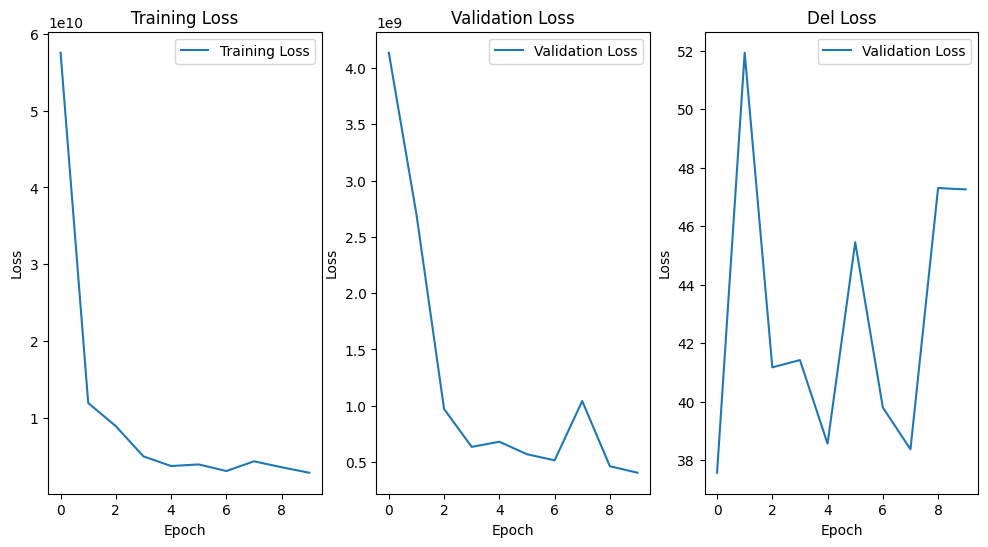

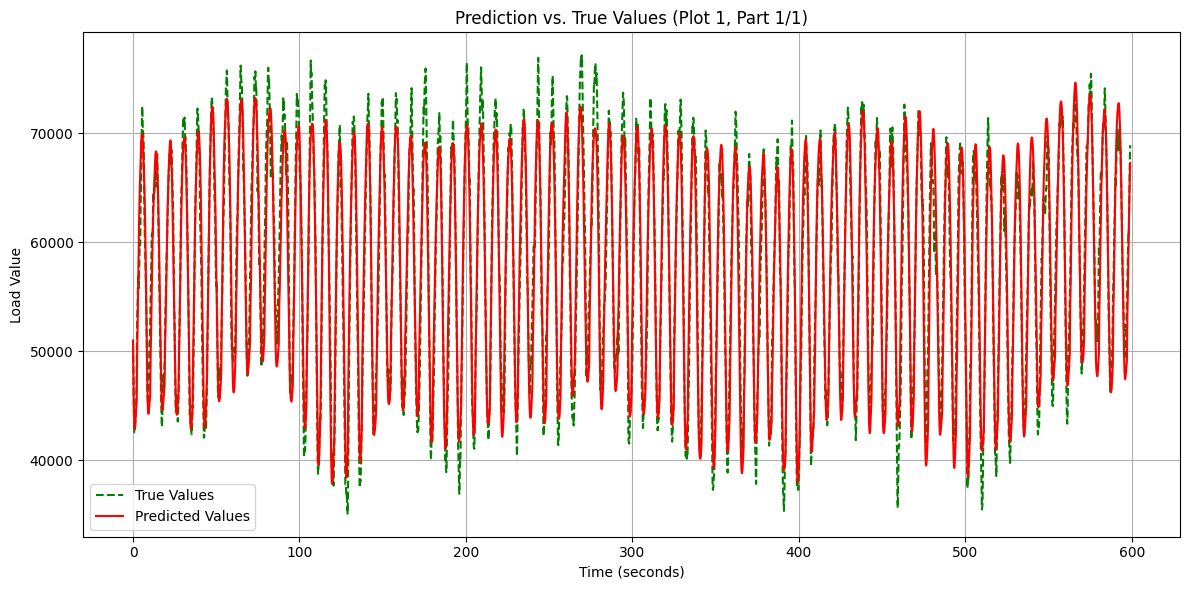

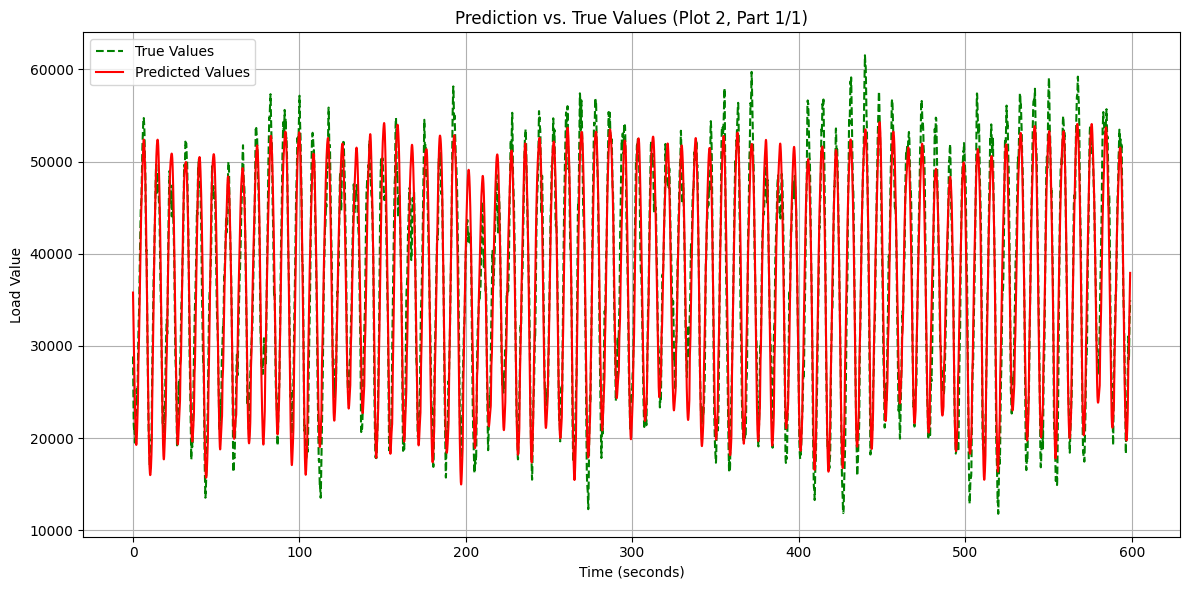

In [10]:
#Define parameters
input_height = 11            # Height of the 2D input field
input_width = 14            # Width of the 2D input field
hidden_dim = 128            # Hidden dimension of LSTM
output_dim = 1              # Output dimension (load value)
num_layers = 3              # Number of LSTM layers
dropout_prob = 0.2          # Dropout_prob of LSTM
kernel_size = 3             # Kernel size for CNN
out_channels = 1            # Output channels of CNN
stride = 1                  # Stride of CNN

learning_rate = 0.0005      # Learning rate optimizer
num_epochs = 10             # Amount of epochs

model = WindTurbineLoadPredictor(hidden_dim=hidden_dim, 
                                 output_dim=output_dim, 
                                 num_layers=num_layers,
                                 kernel_size=kernel_size,
                                 out_channels=out_channels,
                                 stride=stride,
                                 input_height=input_height,
                                 input_width=input_width,
                                 dropout_prob=dropout_prob)


# Clear cache
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print("Device =", device)

# Train the model
trained_model, train_losses, validation_losses, del_losses = train(model, 
                                                       dataloaders, 
                                                       loss_fn, 
                                                       optimizer, 
                                                       num_epochs, 
                                                       device=device, 
                                                       early_stopping_value=-1, 
                                                       print_freq=10)

# Save the trained model
model_save_path = '/kaggle/working/wind_turbine_model.pth'
torch.save(trained_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Plot the training and validation losses
plot_losses(train_losses, validation_losses, del_losses)

# Evaluate the model and plot inference
val_loss, del_loss = evaluate(trained_model, dataloaders['validation'], loss_fn, device=device)
plot_predictions(model=trained_model, dataloader=dataloaders['validation'], num_plots=2)

## Testing

Test error: 4.2569e+08
Final DEL error: 50.309


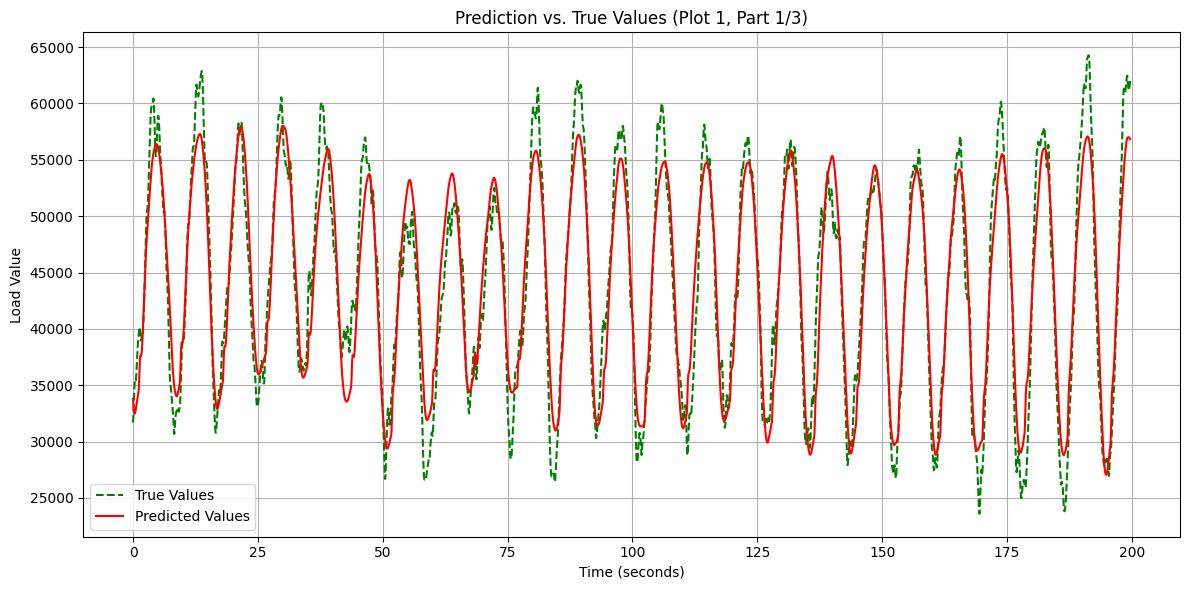

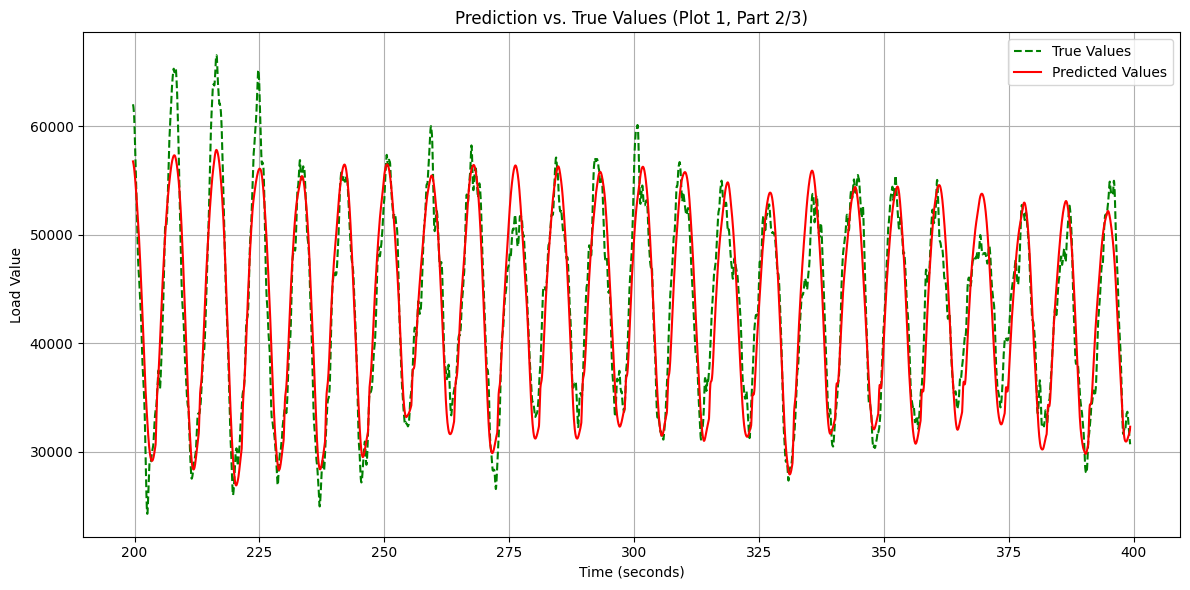

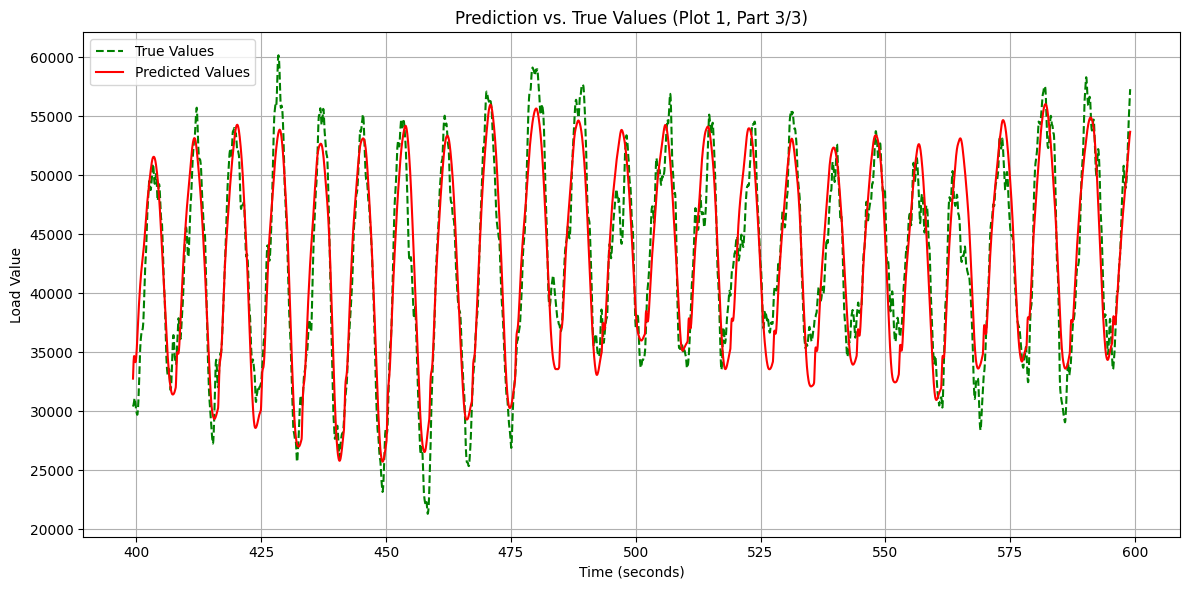

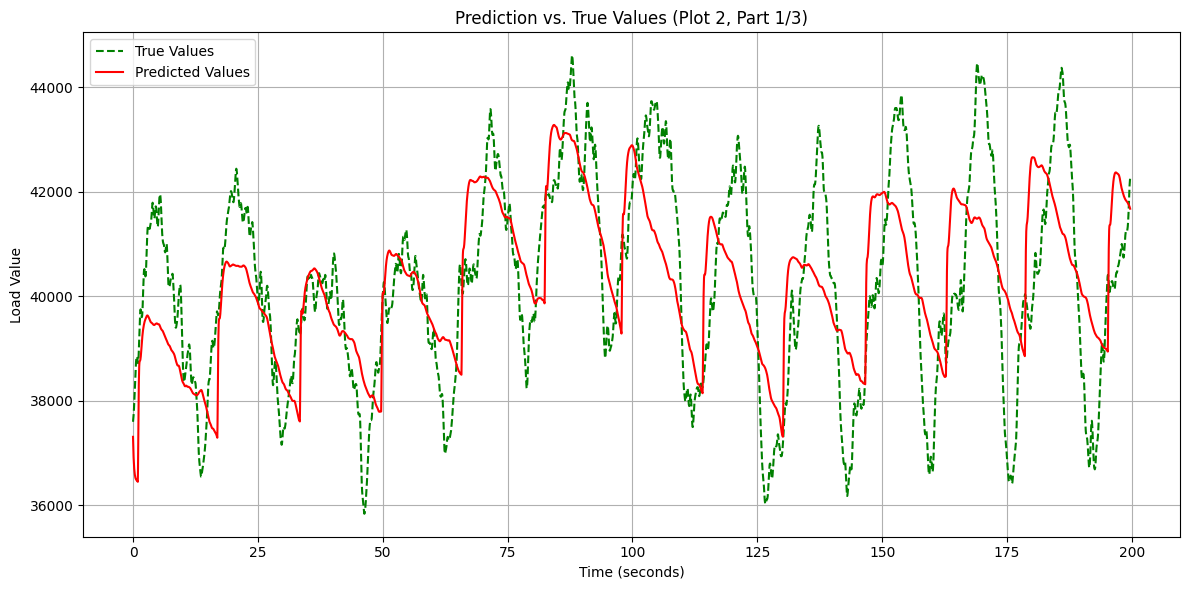

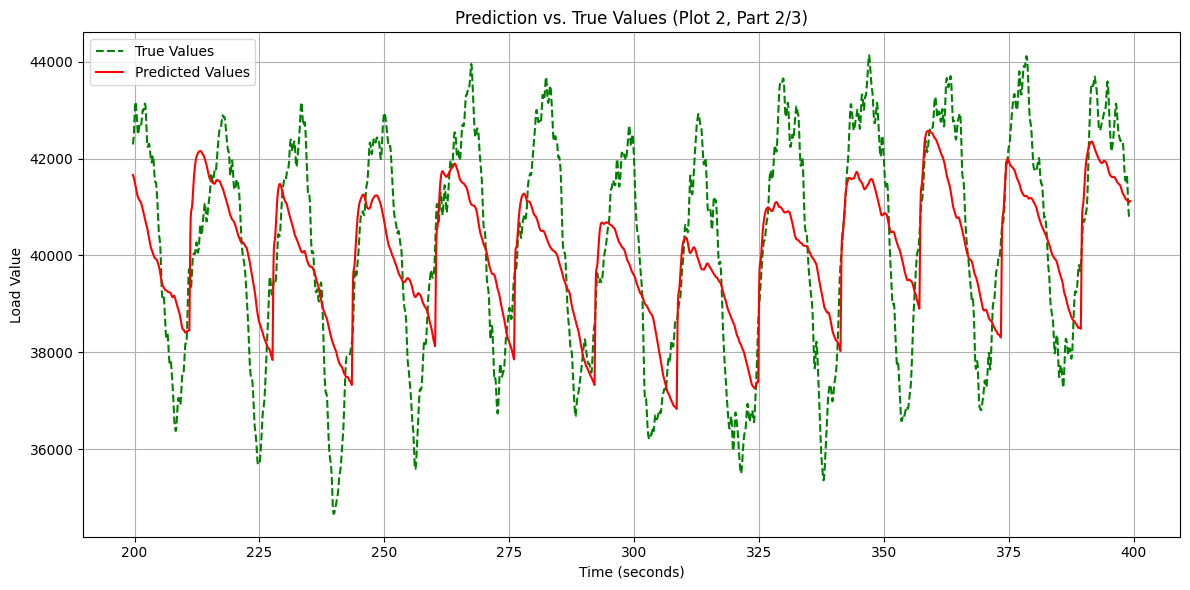

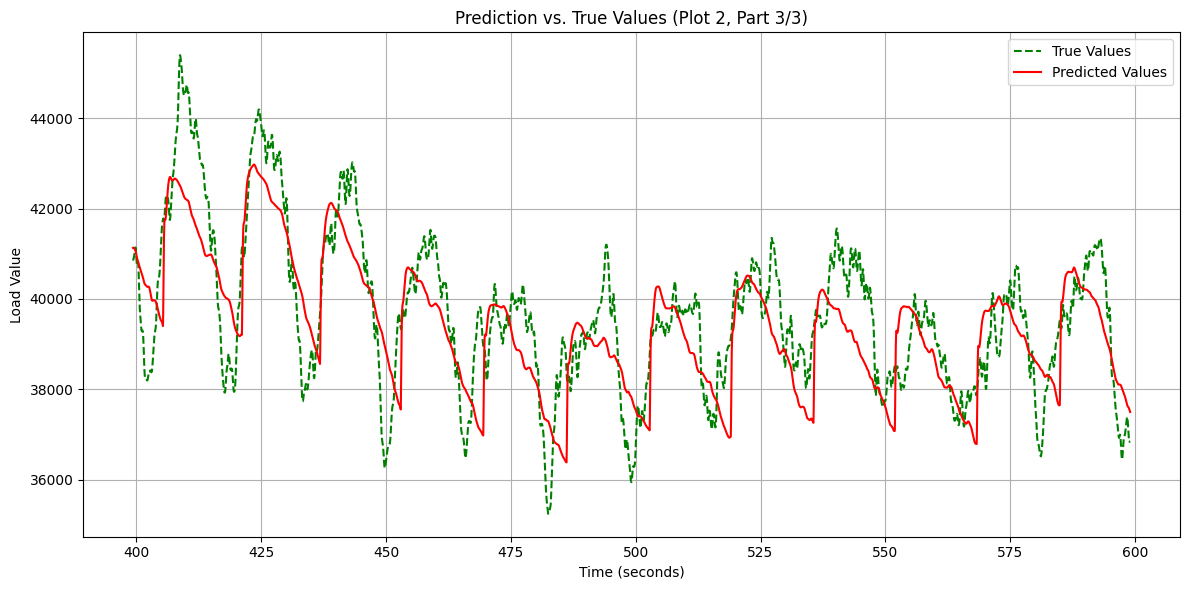

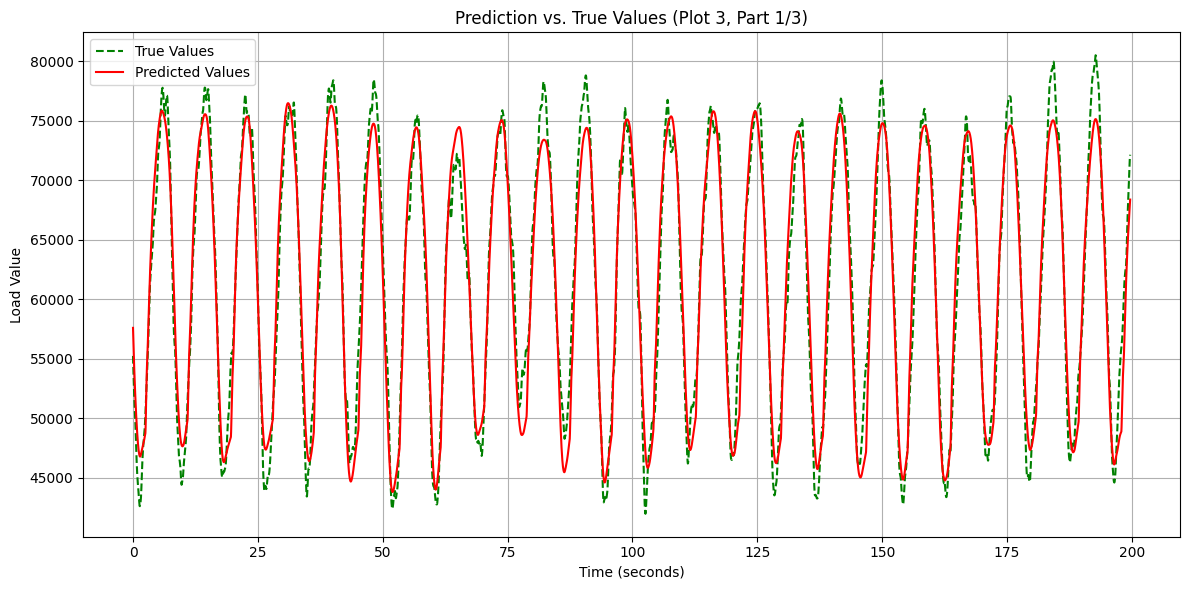

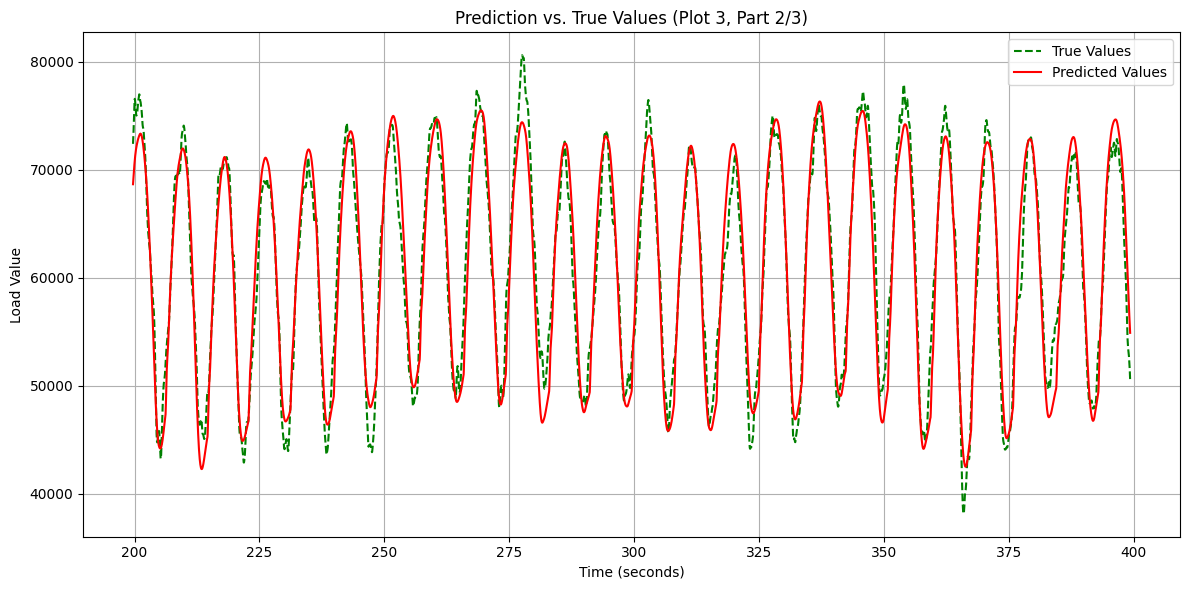

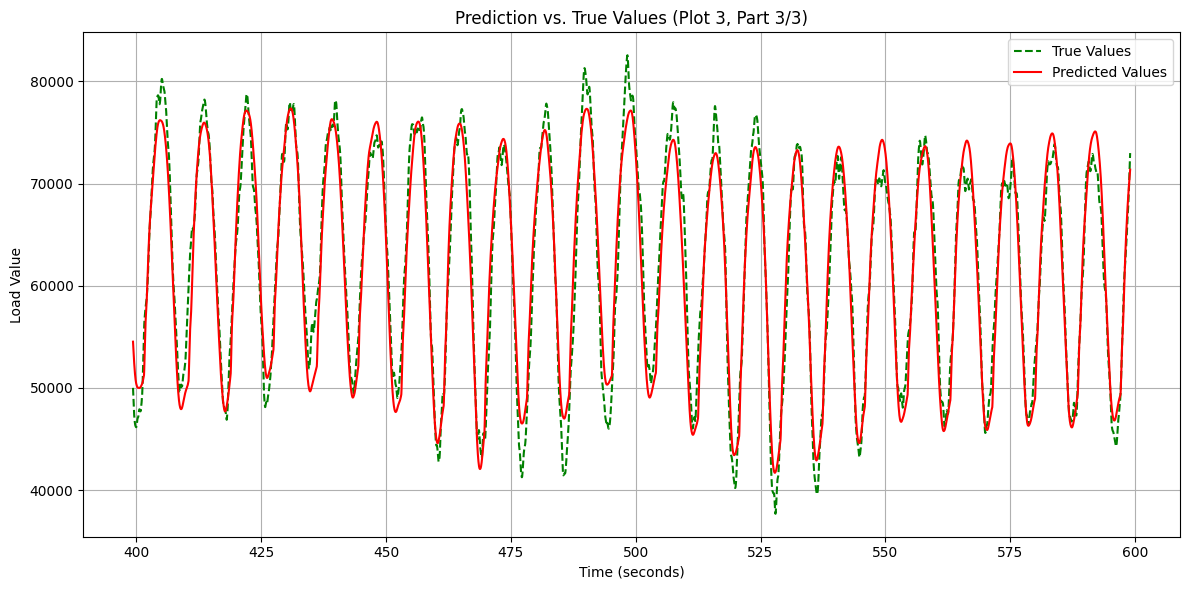

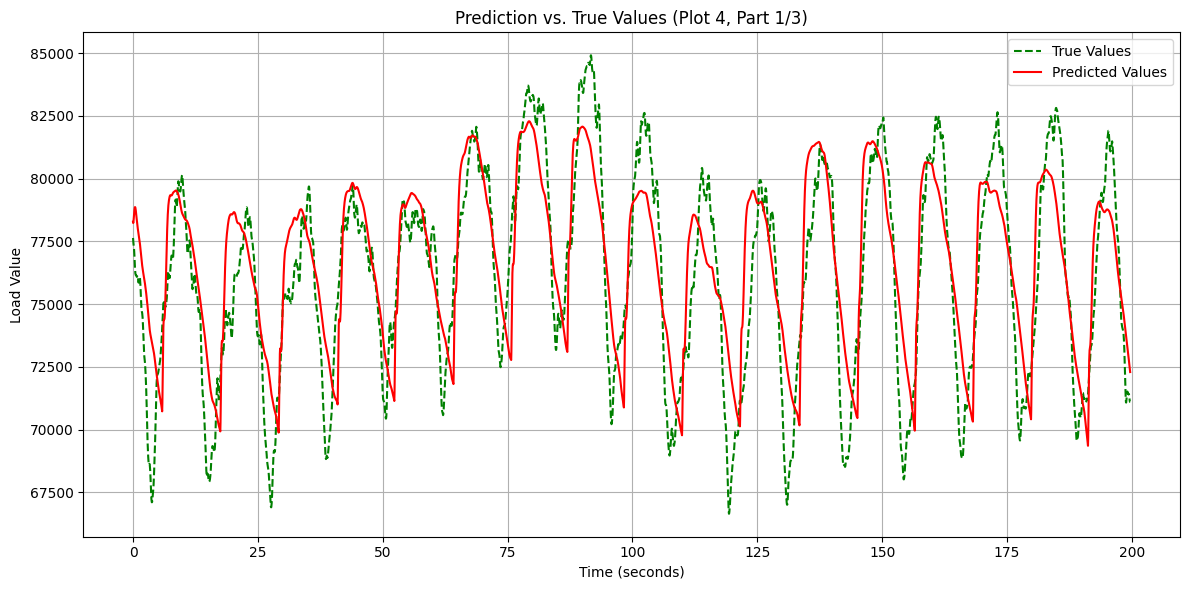

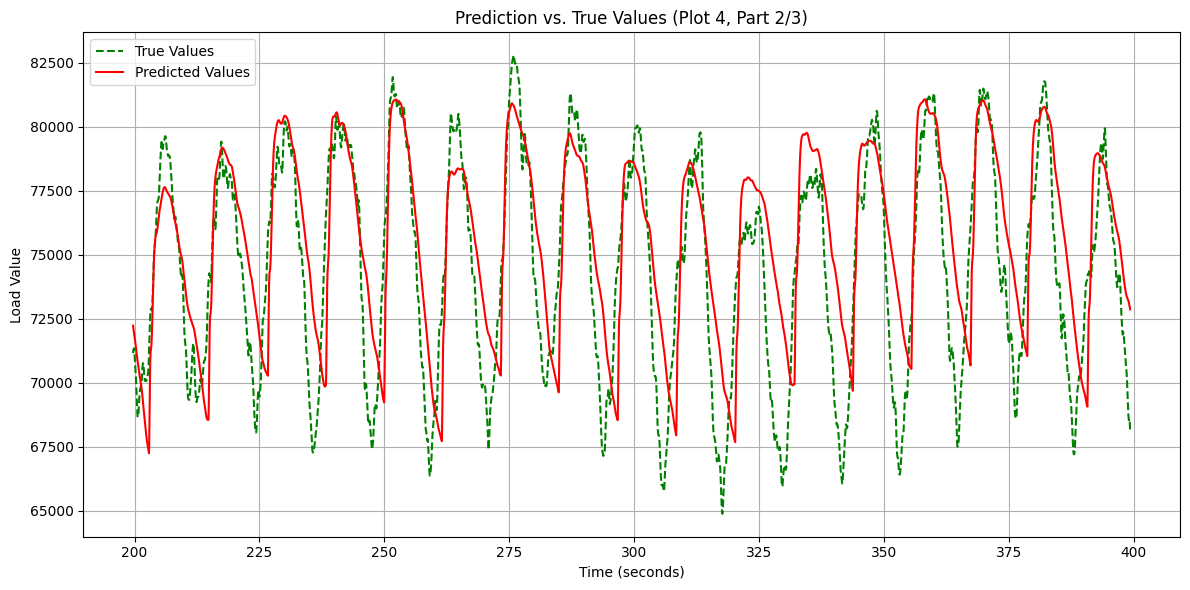

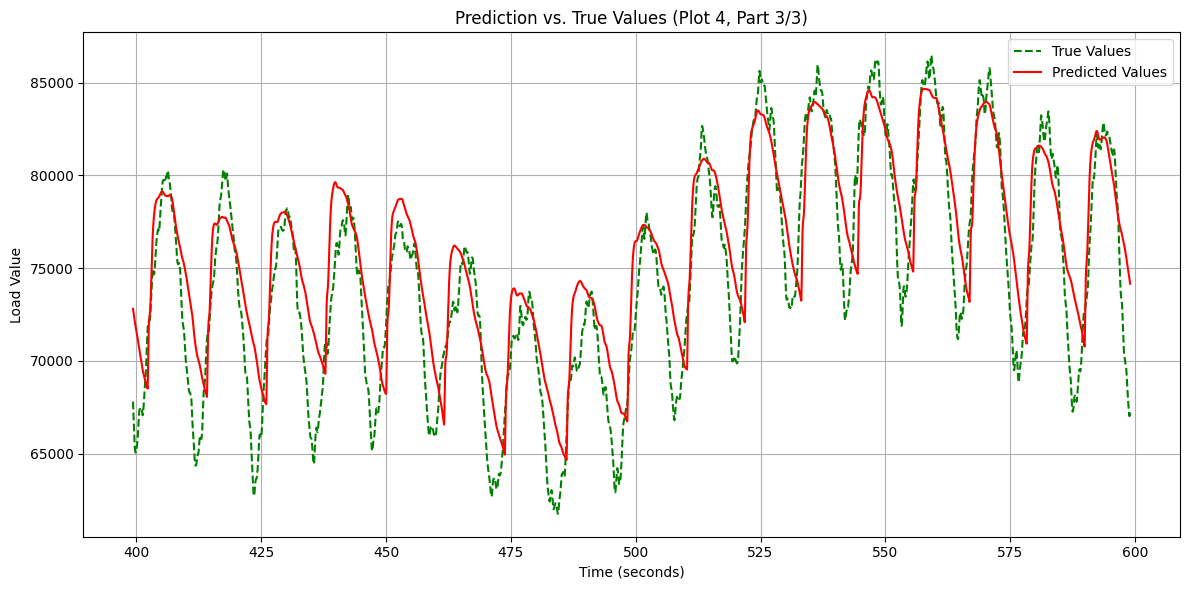

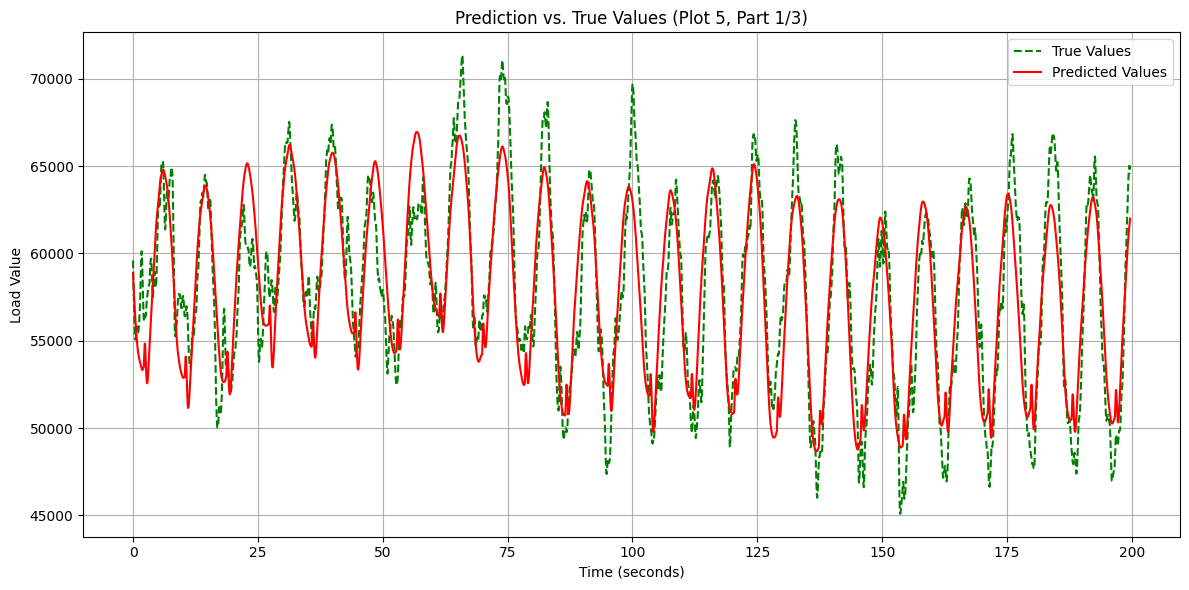

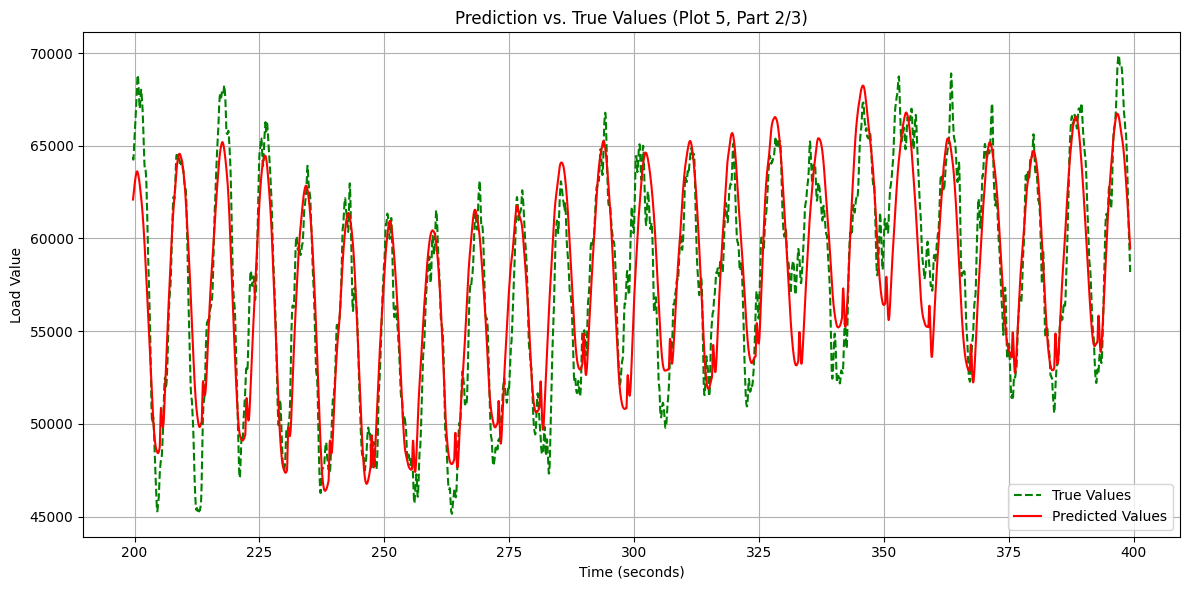

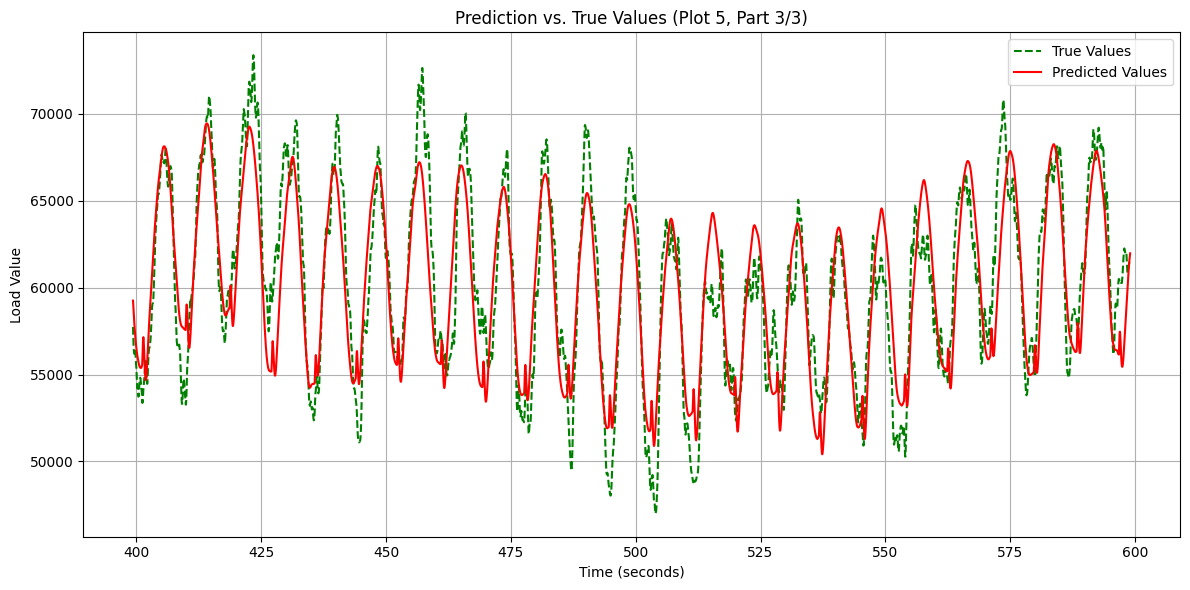

In [13]:
# Evaluate the model and plot inference
test_loss, del_error = evaluate(trained_model, dataloaders['test'], loss_fn, device=device)
print(f'Test error: {test_loss:.4e}')
print(f'Final DEL error: {del_error:.3f}')
plot_predictions(model=trained_model, dataloader=dataloaders['test'], num_parts=3, num_plots=5)